<a href="https://colab.research.google.com/github/sakshisubedi/CSE_256_NLP/blob/main/fewshot/imdb_fewshot_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/CSE_256_Project

/content/drive/MyDrive/CSE_256_Project


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 85.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
df = pd.read_csv('IMDB-Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df['sentiment'] = df['sentiment'].apply(lambda x : 1 if x=='positive' else 0)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
few_shot_df = df.sample(n=100)
len(few_shot_df)

100

In [ ]:
# Split the dataset into train and test sets
train_df, test_df = train_test_split(few_shot_df, test_size=0.2, random_state=42)

In [ ]:
train_df.head()

,review,sentiment
24327,"I saw this when it was in the theater, it star...",0
7353,"""Rush in Rio"" is, no doubt, one of the most ex...",1
17111,Julie Waters is outstanding and Adrian Pasdar ...,1
32006,"What a dreadful movie. The effects were poor, ...",0
47030,I went into this movie expecting a thoughtfull...,0


In [ ]:
len(train_df), len(test_df)

(80, 20)

In [ ]:
# Set up the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Tokenize and encode the text data
train_encodings = tokenizer(list(train_df['review']), truncation=True, padding=True)
test_encodings = tokenizer(list(test_df['review']), truncation=True, padding=True)

In [ ]:
# Create PyTorch tensors
train_labels = torch.tensor(list(train_df['sentiment']))
test_labels = torch.tensor(list(test_df['sentiment']))
train_labels, test_labels

(tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
         1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
         0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
         1, 0, 1, 0, 0, 1, 0, 1]),
 tensor([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]))

In [ ]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), train_labels)
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids']), torch.tensor(test_encodings['attention_mask']), test_labels)

In [ ]:
train_dataset

In [ ]:
# Set up the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [ ]:
# Set up the optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
num_epochs = 5
batch_size = 16

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
import time
train_accuracy_values = []
train_loss_values = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_examples = 0
    s = time.time()

    for batch in train_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predictions = torch.max(logits, dim=1)
        total_correct += torch.sum(predictions == labels).item()
        total_examples += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_accuracy = total_correct / total_examples

    train_loss_values.append(train_loss)
    train_accuracy_values.append(train_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    print("Time taken per epoch", time.time()-s)

Epoch 1/5 - Loss: 0.6626, Accuracy: 0.6375
Time taken per epoch 9.644536256790161
Epoch 2/5 - Loss: 0.6249, Accuracy: 0.8000
Time taken per epoch 6.7899816036224365
Epoch 3/5 - Loss: 0.5677, Accuracy: 0.8250
Time taken per epoch 6.532171010971069
Epoch 4/5 - Loss: 0.4508, Accuracy: 0.9500
Time taken per epoch 6.583731651306152
Epoch 5/5 - Loss: 0.3441, Accuracy: 0.9750
Time taken per epoch 6.631714344024658


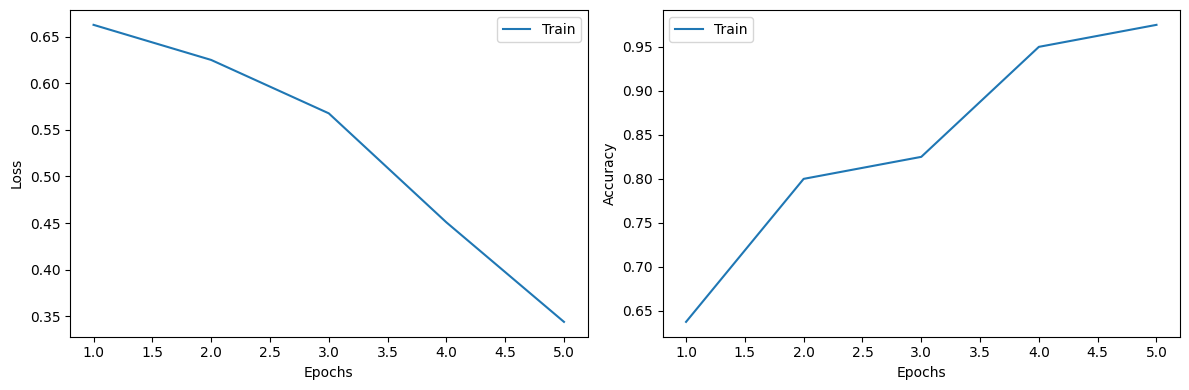

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_loss_values, label='Train')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracy_values, label='Train')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
total_correct = 0
total_examples = 0
predicted_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predictions = torch.max(logits, dim=1)
        total_correct += torch.sum(predictions == labels).item()
        total_examples += labels.size(0)

        predicted_labels.extend(predictions.cpu().numpy())

test_accuracy = total_correct / total_examples
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.8000


In [ ]:
total_correct, total_examples

(16, 20)

In [ ]:
import numpy as np
predicted_labels = np.array(predicted_labels)
predicted_labels

array([1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0])

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(test_labels, predicted_labels)
confusion_mat

array([[7, 2],
       [2, 9]])

Text(0.5, 1.0, 'Confusion Matrix')

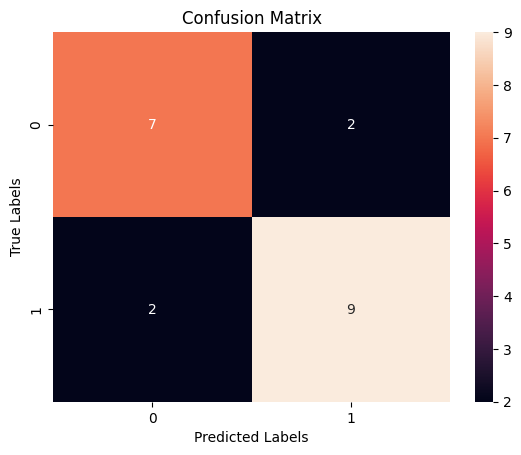

In [ ]:
import seaborn as sns
sns.heatmap(confusion_mat, annot=True)
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')

In [ ]:
# Calculate class-wise accuracy
class_accuracy = np.diagonal(confusion_mat) / np.sum(confusion_mat, axis=1)
print("class-wise accuracy")
class_accuracy

class-wise accuracy


array([0.77777778, 0.81818182])

In [ ]:
# Identify misclassified instances
num_classes = len(confusion_mat)

misclassified_instances = []

for i in range(num_classes):
    for j in range(num_classes):
        if i != j and confusion_mat[i, j] > 0:
            misclassified_instances.append((i, j, confusion_mat[i, j]))
misclassified_instances

[(0, 1, 2), (1, 0, 2)]

In [ ]:
# printing misclassified data
wrong_predictions = 0
for idx, _ in enumerate(predicted_labels):
  if test_df['sentiment'].iloc[idx] != predicted_labels[idx]:
    print(test_df['review'].iloc[idx] + "\n\n")
    wrong_predictions += 1

In film, I feel as though it should be more than just art. I think it should be more than that, a way to tell a story on screen. This short from David Lynch tells a story but not much of one. I felt that it was funny but too bizarre to be a comedy. It is good film-making but there really isn't anything else to it. As I've said before, I am a huge David Lynch fan but I get frustrated by some of his work because I don't see a need for it at all. This is definitely my least favorite thing he has done so far but I know he's still got a ton of talent and I am excited to see what he has in store for us in the future. If you like Lynch, check this out but don't be surprised when you don't like it very much.


A "40 foot long" giant mutant squid with five tentacles, razor fangs and the ability to reproduce it's own cells terrorizes a small Florida town. Various marine biologists, doctors and cops plot to kill it. Meanwhile, a human monster named Miller offs people who discover the "Devilfish" 

In [ ]:
# printing wrong predictions
wrong_predictions

4

In [ ]:
# common misclassification
common_misclassifications = sorted(misclassified_instances, key=lambda x: x[2], reverse=True)
common_misclassifications

[(0, 1, 2), (1, 0, 2)]

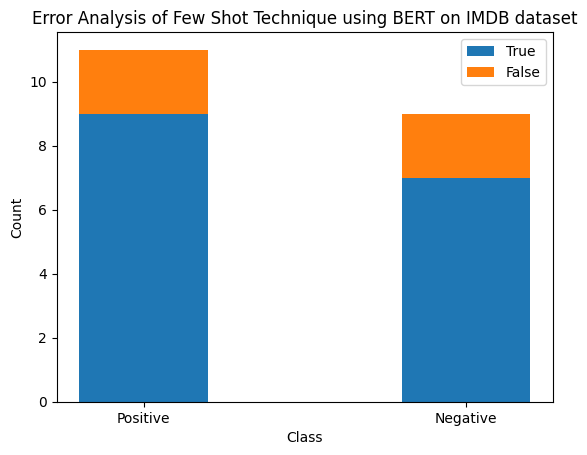

In [ ]:
true_positives = confusion_mat[1, 1]
true_negatives = confusion_mat[0, 0]
false_positives = confusion_mat[0, 1]
false_negatives = confusion_mat[1, 0]

# Set the labels for x-axis
labels = ['Positive', 'Negative']

x = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots()
rects1 = ax.bar(x, [true_positives, true_negatives], width, label='True')
rects2 = ax.bar(x, [false_positives, false_negatives], width, label='False', bottom=[true_positives, true_negatives])

# Set plot title, legend, and axis labels
ax.set_title('Error Analysis of Few Shot Technique using BERT on IMDB dataset')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Show the plot
plt.show()